# Comparison of Music Genre Classification Techniques

## Teammates
Jaden Antoine (jja435), Brian Wu (bw2628), Omni jyothi Gudiguntla (og2148)

## Problem Statement
With the prevalence of streaming services such as Spotify and Apple Music, finding music to listen to has never been easier. These services rely on music genre classification for suggesting new songs to the user. By using a machine learning model, we can perform automatic music genre classification, which alleviates the work of manually classifying millions of songs. In this project, we will compare different models and architectures for music genre classification. Different features will also be experimented with. We will be using test accuracy as our metric for comparison.
##Dataset
We will be using the GTZAN dataset in order to train and classify different genres of music. This dataset is typically used for evaluation in machine learning research for music genre recognition. The dataset itself contains 10 different genres, each with 100 audio files and a length of 30 seconds. The dataset also contains visual representations of each audio file, which neural networks can use to classify genres
##Models
Fully Connected MLP; Logistic Regression; Support Vector Machine;
Convolutional Neural Network Architectures: ResNet, 1D UNet; Transformers


# Get Data

In [ ]:
!sudo apt install libsox-dev
!pip install torchinfo
!pip install torchaudio
!pip install torchaudio_augmentations
!pip install Spectrogram_augmentations
!wget https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/train_filtered.txt
!wget https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/valid_filtered.txt
!wget https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/test_filtered.txt

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libopencore-amrnb0 libopencore-amrwb0
  libsox-fmt-all libsox-fmt-alsa libsox-fmt-ao libsox-fmt-base libsox-fmt-mp3
  libsox-fmt-oss libsox-fmt-pulse libsox3 libwavpack1
Suggested packages:
  libaudio2 libsndio6.1
The following NEW packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libopencore-amrnb0 libopencore-amrwb0
  libsox-dev libsox-fmt-all libsox-fmt-alsa libsox-fmt-ao libsox-fmt-base
  libsox-fmt-mp3 libsox-fmt-oss libsox-fmt-pulse libsox3 libwavpack1
0 upgraded, 16 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,053 kB of archives.
After this operation, 4,061 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libao-common all 1.2.2+20180113-1.1ubuntu3 [6,568 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main

In [ ]:
import os

import numpy as np
import torch
import torch.nn as nn
from torch.utils import data
import torchaudio
from torchaudio.datasets import GTZAN
from torchaudio_augmentations import (
    RandomResizedCrop,
    RandomApply,
    PolarityInversion,
    Noise,
    Gain,
    HighLowPass,
    Delay,
    PitchShift,
    Reverb,
    Compose,
)
from torchinfo import summary
from sklearn.metrics import accuracy_score, confusion_matrix

from transformers import ASTConfig, ASTForAudioClassification, ASTFeatureExtractor

import seaborn as sns
import soundfile as sf
import random
from tqdm import tqdm


# Preprocessing of Data

We download the GTZAN dataset and create a custom Dataset using pytorch to help us split the data in train, valid, and test sets and then load it for our models to use

In [ ]:
GTZAN_GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
SAMPLE_RATE = 22050

GTZAN(root='./', url='https://huggingface.co/datasets/marsyas/gtzan/resolve/main/data/genres.tar.gz?download=true', download=True, subset='training')
# training_data = GTZAN(root='./', url='https://huggingface.co/datasets/marsyas/gtzan/resolve/main/data/genres.tar.gz?download=true', download=True, subset='training')
# test_data = GTZAN(root='./', url='https://huggingface.co/datasets/marsyas/gtzan/resolve/main/data/genres.tar.gz?download=true', download=True, subset='testing')
# val_data = GTZAN(root='./', url='https://huggingface.co/datasets/marsyas/gtzan/resolve/main/data/genres.tar.gz?download=true', download=True, subset='validation')

# train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

configuration = ASTConfig(num_labels=10,hidden_size=384,num_hidden_layers=3,num_attention_heads=3, intermediate_size=768)
feature_extractor = ASTFeatureExtractor(sampling_rate=SAMPLE_RATE)

class GTZANDataset(data.Dataset):
    def __init__(self, data_path, split, num_samples, num_chunks, is_augmentation):
        self.data_path =  data_path if data_path else ''
        self.split = split
        self.num_samples = num_samples
        self.num_chunks = num_chunks
        self.is_augmentation = is_augmentation
        self.genres = GTZAN_GENRES
        self._get_song_list()
        if is_augmentation:
            self._get_augmentations()

    def _get_song_list(self):
        list_filename = os.path.join(self.data_path, '%s_filtered.txt' % self.split)
        with open(list_filename) as f:
            lines = f.readlines()
        self.song_list = [line.strip() for line in lines]

    def _get_augmentations(self):
        transforms = [
            RandomResizedCrop(n_samples=self.num_samples),
            RandomApply([PolarityInversion()], p=0.8),
            RandomApply([Noise(min_snr=0.3, max_snr=0.5)], p=0.3),
            RandomApply([Gain()], p=0.2),
            RandomApply([HighLowPass(sample_rate=22050)], p=0.8),
            RandomApply([Delay(sample_rate=22050)], p=0.5),
            RandomApply([PitchShift(n_samples=self.num_samples, sample_rate=22050)], p=0.4),
            RandomApply([Reverb(sample_rate=22050)], p=0.3),
        ]
        self.augmentation = Compose(transforms=transforms)

    def _adjust_audio_length(self, wav):
        if self.split == 'train':
            random_index = random.randint(0, len(wav) - self.num_samples - 1)
            wav = wav[random_index : random_index + self.num_samples]
        else:
            hop = (len(wav) - self.num_samples) // self.num_chunks
            wav = np.array([wav[i * hop : i * hop + self.num_samples] for i in range(self.num_chunks)])
        return wav

    def __getitem__(self, index):
        line = self.song_list[index]

        # get genre
        genre_name = line.split('/')[0]
        genre_index = self.genres.index(genre_name)

        # get audio
        audio_filename = os.path.join(self.data_path, 'genres', line)
        try:
            wav, fs = sf.read(audio_filename)
        except:
            # print(f"Error: cannot read {audio_filename}")
            # jazz.00054 not working
            line = self.song_list[0]
            genre_name = line.split('/')[0]
            genre_index = self.genres.index(genre_name)
            audio_filename = os.path.join(self.data_path, 'genres', line)
            wav, fs = sf.read(audio_filename)

        # adjust audio length
        wav = self._adjust_audio_length(wav).astype('float32')

        # data augmentation
        if self.is_augmentation:
            wav = self.augmentation(torch.from_numpy(wav).unsqueeze(0)).squeeze(0).numpy()

        ast_features = feature_extractor(wav, SAMPLE_RATE, return_tensors="pt").input_values.squeeze()

        return ast_features, genre_index

        # return wav, genre_index

    def __len__(self):
        return len(self.song_list)

def get_dataloader(data_path=None,
                   split='train',
                   num_samples=22050 * 29,
                   num_chunks=1,
                   batch_size=16,
                   num_workers=0,
                   is_augmentation=False):
    is_shuffle = True if (split == 'train') else False
    batch_size = batch_size if (split == 'train') else (batch_size // num_chunks)
    data_loader = data.DataLoader(dataset=GTZANDataset(data_path,
                                                       split,
                                                       num_samples,
                                                       num_chunks,
                                                       is_augmentation),
                                  batch_size=batch_size,
                                  shuffle=is_shuffle,
                                  drop_last=False,
                                  num_workers=num_workers)
    return data_loader

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)



100%|██████████| 1.14G/1.14G [00:05<00:00, 221MB/s]


cuda:0


We can see the output shape of the data, and the required input shapes for our models is going to be [16,1024,128]

In [ ]:
train_loader = get_dataloader(split='train', is_augmentation=True)
iter_train_loader = iter(train_loader)
train_wav, train_genre = next(iter_train_loader)

valid_loader = get_dataloader(split='valid')
test_loader = get_dataloader(split='test')
iter_test_loader = iter(test_loader)
test_wav, test_genre = next(iter_test_loader)
print('training data shape: %s' % str(train_wav.shape))
print('validation/test data shape: %s' % str(test_wav.shape))
print(train_genre)

training data shape: torch.Size([16, 1024, 128])
validation/test data shape: torch.Size([16, 1024, 128])
tensor([3, 1, 8, 6, 6, 7, 1, 1, 0, 1, 1, 7, 1, 6, 3, 7])


# Omni



## Logistic Regression

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from torchinfo import summary

# Define logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 32000)
        self.output = nn.Sequential(
            nn.Linear(32000, output_dim),
            nn.AdaptiveAvgPool2d((10,1)),
            nn.Flatten()
        )
        #self.avg =
        #self.flatten =

    def forward(self, x):
        logits = self.linear(x)
        #print(logits.shape)
        #logits = self.avg(logits)
        #print(logits.shape)
        logits = self.output(logits)
        #print(logits.shape)
        return logits

def train_logistic_regression(num_epochs, model, criterion, optimizer, train_loader, valid_loader, device):
    train_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            num_classes=10
            # One-hot encode the labels
            one_hot_labels = nn.functional.one_hot(labels, num_classes)

            loss = criterion(outputs, one_hot_labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation
        model.eval()
        epoch_valid_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                # One-hot encode the labels
                one_hot_labels = nn.functional.one_hot(labels, num_classes)

                loss = criterion(outputs, one_hot_labels)
                epoch_valid_loss += loss.item()
            valid_losses.append(epoch_valid_loss / len(valid_loader))

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Valid Loss: {valid_losses[-1]}")

    return train_losses, valid_losses

# Instantiate logistic regression model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 128  # Adjusted input size to match the actual input data size
output_dim = 10  # Number of classes
lr_model = LogisticRegression(input_dim, output_dim).to(device)

# Define cross-entropy loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer (e.g., Adam)
optimizer = optim.Adam(lr_model.parameters(), lr=0.001)

# Get model summary
summary(lr_model)


Layer (type:depth-idx)                   Param #
LogisticRegression                       --
├─Linear: 1-1                            4,128,000
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       320,010
│    └─AdaptiveAvgPool2d: 2-2            --
│    └─Flatten: 2-3                      --
Total params: 4,448,010
Trainable params: 4,448,010
Non-trainable params: 0

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: [1/50], Train loss: 2.4646


  2%|▏         | 1/50 [01:01<50:01, 61.25s/it]

Epoch: [1/50], Valid loss: 2.3716, Valid accuracy: 0.1168
Saving the best model at 0 epochs!
Epoch: [2/50], Train loss: 2.3570


  4%|▍         | 2/50 [02:05<50:29, 63.12s/it]

Epoch: [2/50], Valid loss: 2.3752, Valid accuracy: 0.0914
Epoch: [3/50], Train loss: 2.3305


  6%|▌         | 3/50 [03:07<48:57, 62.50s/it]

Epoch: [3/50], Valid loss: 2.3777, Valid accuracy: 0.0812
Epoch: [4/50], Train loss: 2.3548


  8%|▊         | 4/50 [04:09<47:41, 62.21s/it]

Epoch: [4/50], Valid loss: 2.3886, Valid accuracy: 0.1117
Epoch: [5/50], Train loss: 2.3932


 10%|█         | 5/50 [05:07<45:42, 60.94s/it]

Epoch: [5/50], Valid loss: 2.3506, Valid accuracy: 0.1117
Saving the best model at 4 epochs!
Epoch: [6/50], Train loss: 2.3658


 12%|█▏        | 6/50 [06:09<44:52, 61.19s/it]

Epoch: [6/50], Valid loss: 2.3412, Valid accuracy: 0.0711
Saving the best model at 5 epochs!
Epoch: [7/50], Train loss: 2.3434


 14%|█▍        | 7/50 [07:13<44:28, 62.07s/it]

Epoch: [7/50], Valid loss: 2.3561, Valid accuracy: 0.0711
Epoch: [8/50], Train loss: 2.3618


 16%|█▌        | 8/50 [08:12<42:51, 61.23s/it]

Epoch: [8/50], Valid loss: 2.3712, Valid accuracy: 0.1015
Epoch: [9/50], Train loss: 2.3461


 18%|█▊        | 9/50 [09:10<41:04, 60.10s/it]

Epoch: [9/50], Valid loss: 2.3975, Valid accuracy: 0.1015
Epoch: [10/50], Train loss: 2.3781


 20%|██        | 10/50 [10:12<40:23, 60.59s/it]

Epoch: [10/50], Valid loss: 2.5845, Valid accuracy: 0.1168
Epoch: [11/50], Train loss: 2.3719


 22%|██▏       | 11/50 [11:14<39:46, 61.20s/it]

Epoch: [11/50], Valid loss: 2.3475, Valid accuracy: 0.0660
Epoch: [12/50], Train loss: 2.3411


 24%|██▍       | 12/50 [12:17<39:06, 61.75s/it]

Epoch: [12/50], Valid loss: 2.3491, Valid accuracy: 0.0761
Epoch: [13/50], Train loss: 2.3567


 26%|██▌       | 13/50 [13:19<38:00, 61.64s/it]

Epoch: [13/50], Valid loss: 2.3618, Valid accuracy: 0.0761
Epoch: [14/50], Train loss: 2.3580


 28%|██▊       | 14/50 [14:22<37:18, 62.17s/it]

Epoch: [14/50], Valid loss: 2.3601, Valid accuracy: 0.0863
Epoch: [15/50], Train loss: 2.3573


 30%|███       | 15/50 [15:27<36:50, 63.15s/it]

Epoch: [15/50], Valid loss: 2.3818, Valid accuracy: 0.0964
Epoch: [16/50], Train loss: 2.3640


 32%|███▏      | 16/50 [16:32<35:58, 63.50s/it]

Epoch: [16/50], Valid loss: 2.3437, Valid accuracy: 0.1218
Epoch: [17/50], Train loss: 2.3126


 34%|███▍      | 17/50 [17:35<34:52, 63.42s/it]

Epoch: [17/50], Valid loss: 2.3924, Valid accuracy: 0.0914
Epoch: [18/50], Train loss: 2.3446


 36%|███▌      | 18/50 [18:36<33:29, 62.80s/it]

Epoch: [18/50], Valid loss: 2.3537, Valid accuracy: 0.0964
Epoch: [19/50], Train loss: 2.3500


 38%|███▊      | 19/50 [19:37<32:08, 62.20s/it]

Epoch: [19/50], Valid loss: 2.3706, Valid accuracy: 0.1168
Epoch: [20/50], Train loss: 2.3487


 40%|████      | 20/50 [20:43<31:40, 63.36s/it]

Epoch: [20/50], Valid loss: 2.3404, Valid accuracy: 0.1066
Saving the best model at 19 epochs!
Epoch: [21/50], Train loss: 2.3369


 42%|████▏     | 21/50 [21:49<30:54, 63.96s/it]

Epoch: [21/50], Valid loss: 2.3323, Valid accuracy: 0.1168
Saving the best model at 20 epochs!
Epoch: [22/50], Train loss: 2.3436


 44%|████▍     | 22/50 [22:52<29:44, 63.74s/it]

Epoch: [22/50], Valid loss: 2.3500, Valid accuracy: 0.0761
Epoch: [23/50], Train loss: 2.3327


 46%|████▌     | 23/50 [23:53<28:20, 62.99s/it]

Epoch: [23/50], Valid loss: 2.3318, Valid accuracy: 0.0761
Saving the best model at 22 epochs!
Epoch: [24/50], Train loss: 2.3237


 48%|████▊     | 24/50 [24:51<26:39, 61.53s/it]

Epoch: [24/50], Valid loss: 2.4667, Valid accuracy: 0.1117
Epoch: [25/50], Train loss: 2.3443


 50%|█████     | 25/50 [25:55<25:52, 62.10s/it]

Epoch: [25/50], Valid loss: 2.3718, Valid accuracy: 0.0761
Epoch: [26/50], Train loss: 2.3622


 52%|█████▏    | 26/50 [26:57<24:49, 62.08s/it]

Epoch: [26/50], Valid loss: 2.3860, Valid accuracy: 0.1015
Epoch: [27/50], Train loss: 2.3469


 54%|█████▍    | 27/50 [28:02<24:08, 62.97s/it]

Epoch: [27/50], Valid loss: 2.3684, Valid accuracy: 0.0964
Epoch: [28/50], Train loss: 2.3513


 56%|█████▌    | 28/50 [29:04<23:00, 62.76s/it]

Epoch: [28/50], Valid loss: 2.3493, Valid accuracy: 0.0609
Epoch: [29/50], Train loss: 2.3363


 58%|█████▊    | 29/50 [30:09<22:10, 63.35s/it]

Epoch: [29/50], Valid loss: 2.3660, Valid accuracy: 0.0914
Epoch: [30/50], Train loss: 2.3196


 60%|██████    | 30/50 [31:09<20:45, 62.29s/it]

Epoch: [30/50], Valid loss: 2.3378, Valid accuracy: 0.0660
Epoch: [31/50], Train loss: 2.3623


 62%|██████▏   | 31/50 [32:15<20:05, 63.46s/it]

Epoch: [31/50], Valid loss: 2.3596, Valid accuracy: 0.0863
Epoch: [32/50], Train loss: 2.3668


 64%|██████▍   | 32/50 [33:21<19:19, 64.41s/it]

Epoch: [32/50], Valid loss: 2.3300, Valid accuracy: 0.0914
Saving the best model at 31 epochs!
Epoch: [33/50], Train loss: 2.3460


 66%|██████▌   | 33/50 [34:22<17:55, 63.29s/it]

Epoch: [33/50], Valid loss: 2.3122, Valid accuracy: 0.0863
Saving the best model at 32 epochs!
Epoch: [34/50], Train loss: 2.3529


 68%|██████▊   | 34/50 [35:24<16:48, 63.03s/it]

Epoch: [34/50], Valid loss: 2.4769, Valid accuracy: 0.0711
Epoch: [35/50], Train loss: 2.3714


 70%|███████   | 35/50 [36:27<15:44, 62.99s/it]

Epoch: [35/50], Valid loss: 2.3765, Valid accuracy: 0.0660
Epoch: [36/50], Train loss: 2.3670


 72%|███████▏  | 36/50 [37:29<14:37, 62.65s/it]

Epoch: [36/50], Valid loss: 2.3300, Valid accuracy: 0.1168
Epoch: [37/50], Train loss: 2.3460


 74%|███████▍  | 37/50 [38:33<13:38, 62.93s/it]

Epoch: [37/50], Valid loss: 2.3392, Valid accuracy: 0.0914
Epoch: [38/50], Train loss: 2.3404


 76%|███████▌  | 38/50 [39:36<12:35, 63.00s/it]

Epoch: [38/50], Valid loss: 2.3452, Valid accuracy: 0.0964
Epoch: [39/50], Train loss: 2.3335


 78%|███████▊  | 39/50 [40:40<11:37, 63.43s/it]

Epoch: [39/50], Valid loss: 2.4230, Valid accuracy: 0.1066
Epoch: [40/50], Train loss: 2.3526


 80%|████████  | 40/50 [41:37<10:14, 61.48s/it]

Epoch: [40/50], Valid loss: 2.3275, Valid accuracy: 0.1117
Epoch: [41/50], Train loss: 2.3313


 82%|████████▏ | 41/50 [42:38<09:11, 61.28s/it]

Epoch: [41/50], Valid loss: 2.3689, Valid accuracy: 0.0863
Epoch: [42/50], Train loss: 2.3352


 84%|████████▍ | 42/50 [43:39<08:08, 61.05s/it]

Epoch: [42/50], Valid loss: 2.3349, Valid accuracy: 0.1015
Epoch: [43/50], Train loss: 2.3306


 86%|████████▌ | 43/50 [44:38<07:04, 60.59s/it]

Epoch: [43/50], Valid loss: 2.4328, Valid accuracy: 0.1117
Epoch: [44/50], Train loss: 2.3422


 88%|████████▊ | 44/50 [45:39<06:03, 60.57s/it]

Epoch: [44/50], Valid loss: 2.3639, Valid accuracy: 0.0863
Epoch: [45/50], Train loss: 2.3606


 90%|█████████ | 45/50 [46:39<05:02, 60.47s/it]

Epoch: [45/50], Valid loss: 2.3872, Valid accuracy: 0.1066
Epoch: [46/50], Train loss: 2.3339


 92%|█████████▏| 46/50 [47:41<04:03, 60.90s/it]

Epoch: [46/50], Valid loss: 2.4289, Valid accuracy: 0.0964
Epoch: [47/50], Train loss: 2.3369


 94%|█████████▍| 47/50 [48:40<03:00, 60.31s/it]

Epoch: [47/50], Valid loss: 2.3400, Valid accuracy: 0.1015
Epoch: [48/50], Train loss: 2.3377


 96%|█████████▌| 48/50 [49:41<02:01, 60.62s/it]

Epoch: [48/50], Valid loss: 2.4078, Valid accuracy: 0.0812
Epoch: [49/50], Train loss: 2.3090


 98%|█████████▊| 49/50 [50:41<01:00, 60.36s/it]

Epoch: [49/50], Valid loss: 2.3351, Valid accuracy: 0.0914
Epoch: [50/50], Train loss: 2.3102


100%|██████████| 50/50 [51:41<00:00, 62.03s/it]

Epoch: [50/50], Valid loss: 2.4293, Valid accuracy: 0.1015


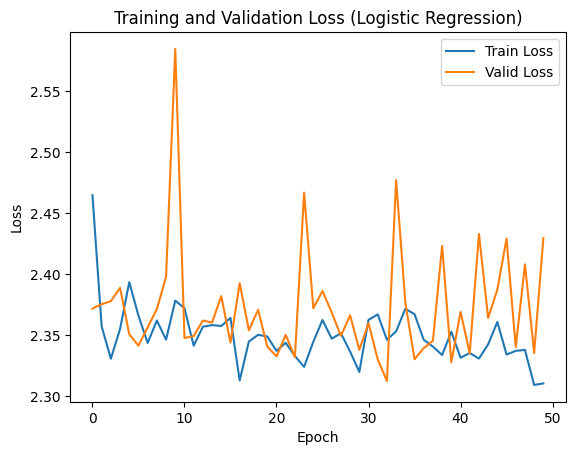

In [ ]:
# Train the logistic regression model
num_epochs = 50
#train_losses_lr, valid_losses_lr = train_logistic_regression(num_epochs, lr_model, criterion, optimizer, train_loader, valid_loader, device)
train_losses_lr, valid_losses_lr, valid_accuracy_lr = train_loop(num_epochs, lr_model, criterion, optimizer, train_loader, valid_loader)
#rain_losses_lr, valid_losses_lr = train_loop(num_epochs, lr_model, criterion, optimizer, train_loader, valid_loader, device)

# Plot training and validation losses
plt.plot(train_losses_lr, label='Train Loss')
plt.plot(valid_losses_lr, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Logistic Regression)')
plt.legend()
plt.show()

Accuracy: 0.1034


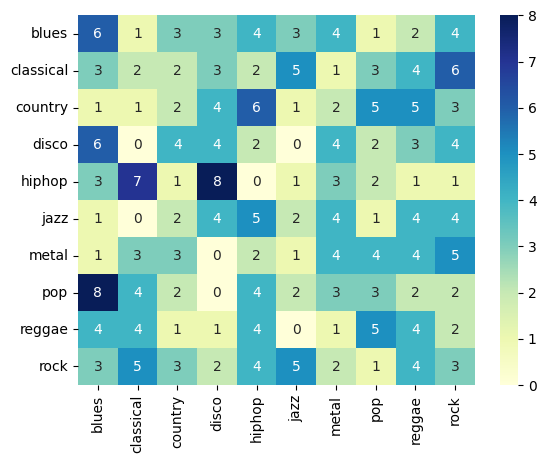

In [ ]:
evaluation(lr_model)

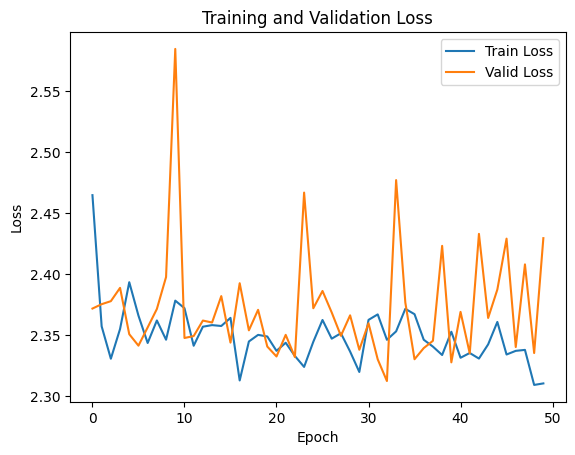

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses_lr, label='Train Loss')
plt.plot(valid_losses_lr, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

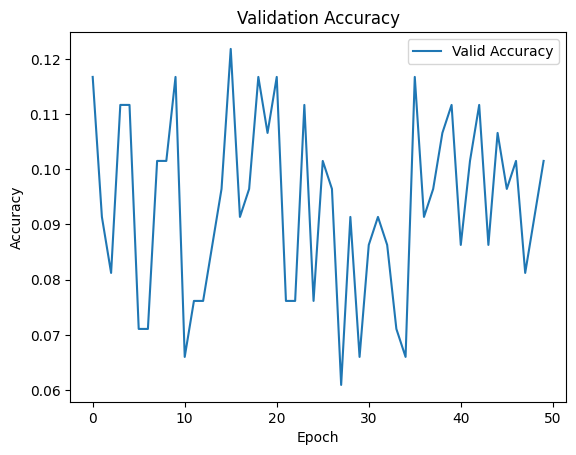

In [ ]:
plt.plot(valid_accuracy_lr, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

## SVM

In [ ]:
import torch
import torch.nn as nn
from sklearn import svm
from sklearn.metrics import accuracy_score

# Define SVM model
class SVM(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SVM, self).__init__()
        self.input_dim = input_dim
        self.svm = svm.LinearSVC(C=100000.0)

    def forward(self, x):
        # No forward pass needed for SVM
        pass

# Train the SVM model
def train_svm(model, train_loader):
    for inputs, labels in train_loader:
        # Reshape inputs to 1D tensor
        inputs = inputs.view(inputs.size(0), -1)

        # Convert labels to numpy array
        labels = labels.numpy()

        # Flatten inputs
        inputs_flat = inputs.numpy()

        # Train SVM
        model.svm.fit(inputs_flat, labels)

# Compute accuracy
def compute_accuracy(model, data_loader):
    all_preds = []
    all_labels = []
    for inputs, labels in data_loader:
        inputs_flat = inputs.view(inputs.size(0), -1)
        preds = model.svm.predict(inputs_flat)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
    acc = accuracy_score(all_labels, all_preds)
    return acc

# Instantiate SVM model
input_dim = 4e6 / 10 - 1
num_classes = 10  # Number of classes
svm_model = SVM(int(input_dim), num_classes)

# Train the SVM model
train_svm(svm_model, train_loader)

# Compute accuracy on train and test datasets
train_accuracy = compute_accuracy(svm_model, train_loader)
test_accuracy = compute_accuracy(svm_model, test_loader)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.07900677200902935
Test Accuracy: 0.1724137931034483


Test Accuracy (SVM): 0.1896551724137931


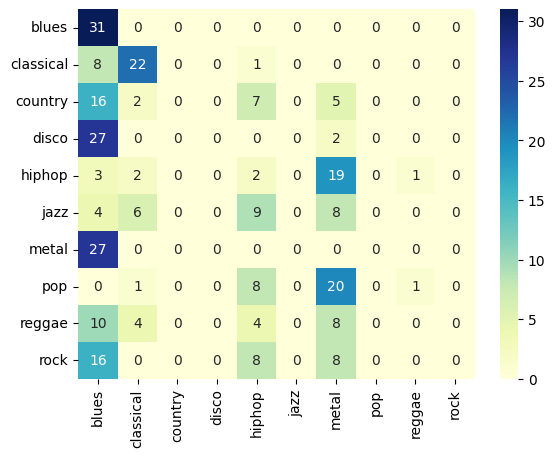

In [ ]:
def evaluation(model, test_loader):
    y_true_list = []
    y_pred_list = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.view(x.size(0), -1)  # Flatten the input data
            inputs_flat = x.numpy()    # Convert input data to numpy array
            preds = model.svm.predict(inputs_flat)  # Use SVM's predict method

            # append labels and predictions
            y_true_list.extend(y.numpy())
            y_pred_list.extend(preds)

    accuracy = accuracy_score(y_true_list, y_pred_list)
    cm = confusion_matrix(y_true_list, y_pred_list)
    sns.heatmap(cm, annot=True, xticklabels=GTZAN_GENRES, yticklabels=GTZAN_GENRES, cmap='YlGnBu')
    return accuracy, cm
test_accuracy_svm, confusion_matrix_svm = evaluation(svm_model, test_loader)
print(f'Test Accuracy (SVM): {test_accuracy_svm}')


# Jaden



## ResNet

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv_in = nn.Conv2d(1,3, kernel_size = 3, stride=1, padding=0)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)
        self.avg_pool_adapt = nn.AdaptiveAvgPool2d((1,1))

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        #print(x.shape)
        x= x.unsqueeze_(1)
        #print(x.shape)
        x = self.conv_in(x)
        out = F.relu(self.bn1(self.conv1(x)))
        #print(out.shape)
        out = self.layer1(out)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = self.layer3(out)
        #print(out.shape)
        out = self.layer4(out)
        #print(out.shape)
        #out = F.avg_pool2d(out, 4)
        #out = F.adaptive_avg_pool2d(out,4)
        out = self.avg_pool_adapt(out)
        #print(out.shape)
        #out = out.view( -1, out.size( 1 ))
        #out = out.view(out.size(0), -1)
        out = torch.flatten(out,1)
        #print(out.shape)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

resnet = ResNet18().to(DEVICE)

## UNet

In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128, 256)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)

    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])

    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128, 256), dec_chs=(256, 128, 64), num_class=10, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.input = nn.Conv2d(1,3, kernel_size = 3, stride=1, padding=1)
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
            #nn.Linear(16, 10)
        )
        #self.avg_pool_adapt = nn.AdaptiveAvgPool2d((1,1))
        #self.linear = nn.Linear(16, num_classes)

    def forward(self, x):
        x = x.unsqueeze_(1)
        x = self.input(x)
        #print(x.shape)
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        #print(out.shape)
        out      = self.head(out)
        #print(out.shape)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        out = self.fc(out)
        #print(out.shape)
        return out

unet = UNet().to(DEVICE)

In [ ]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
unet_optimizer = optim.Adam(unet.parameters(), lr=learning_rate)
resnet_optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)

## Train ResNet

In [ ]:
# Train ResNet
num_epochs = 50
print(resnet)
print(train_wav.shape)
print(summary(resnet,train_wav.shape)) #[16,1024,128]

ResNet(
  (conv_in): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [ ]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_losses_resnet, valid_losses_resnet, valid_accuracy_resnet = train_loop(num_epochs, resnet, criterion, resnet_optimizer, train_loader, valid_loader)

#num_epochs = 50
#for epoch in range(num_epochs):
#    train_loss, train_acc = train(resnet, resnet_optimizer, criterion, train_loader, device)
#    test_loss, test_acc = test(resnet, criterion, valid_loader, device) # use validation data

#    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Validation Loss: {test_loss:.4f}, Validation Acc: {test_acc:.2f}%')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: [1/50], Train loss: 2.3912


  2%|▏         | 1/50 [01:03<51:54, 63.56s/it]

Epoch: [1/50], Valid loss: 2.3554, Valid accuracy: 0.1168
Saving the best model at 0 epochs!
Epoch: [2/50], Train loss: 2.2550


  4%|▍         | 2/50 [02:05<50:12, 62.76s/it]

Epoch: [2/50], Valid loss: 2.2593, Valid accuracy: 0.1827
Saving the best model at 1 epochs!
Epoch: [3/50], Train loss: 2.2474


  6%|▌         | 3/50 [03:06<48:37, 62.07s/it]

Epoch: [3/50], Valid loss: 2.4204, Valid accuracy: 0.1015
Epoch: [4/50], Train loss: 2.1450


  8%|▊         | 4/50 [04:09<47:44, 62.27s/it]

Epoch: [4/50], Valid loss: 2.0551, Valid accuracy: 0.2487
Saving the best model at 3 epochs!
Epoch: [5/50], Train loss: 2.1323


 10%|█         | 5/50 [05:10<46:25, 61.89s/it]

Epoch: [5/50], Valid loss: 3.5582, Valid accuracy: 0.1878
Epoch: [6/50], Train loss: 2.0286


 12%|█▏        | 6/50 [06:11<45:04, 61.46s/it]

Epoch: [6/50], Valid loss: 1.8800, Valid accuracy: 0.3046
Saving the best model at 5 epochs!
Epoch: [7/50], Train loss: 2.0707


 14%|█▍        | 7/50 [07:12<43:56, 61.31s/it]

Epoch: [7/50], Valid loss: 1.9102, Valid accuracy: 0.3147
Epoch: [8/50], Train loss: 2.0174


 16%|█▌        | 8/50 [08:14<43:07, 61.62s/it]

Epoch: [8/50], Valid loss: 1.9052, Valid accuracy: 0.2944
Epoch: [9/50], Train loss: 1.9815


 18%|█▊        | 9/50 [09:16<42:06, 61.62s/it]

Epoch: [9/50], Valid loss: 2.4571, Valid accuracy: 0.2234
Epoch: [10/50], Train loss: 1.8851


 20%|██        | 10/50 [10:20<41:30, 62.25s/it]

Epoch: [10/50], Valid loss: 6.3645, Valid accuracy: 0.1269
Epoch: [11/50], Train loss: 1.9756


 22%|██▏       | 11/50 [11:22<40:28, 62.26s/it]

Epoch: [11/50], Valid loss: 2.5471, Valid accuracy: 0.1320
Epoch: [12/50], Train loss: 1.9457


 24%|██▍       | 12/50 [12:28<40:12, 63.49s/it]

Epoch: [12/50], Valid loss: 8.5554, Valid accuracy: 0.1574
Epoch: [13/50], Train loss: 1.8564


 26%|██▌       | 13/50 [13:30<38:53, 63.06s/it]

Epoch: [13/50], Valid loss: 1.7599, Valid accuracy: 0.3096
Saving the best model at 12 epochs!
Epoch: [14/50], Train loss: 1.8820


 28%|██▊       | 14/50 [14:33<37:50, 63.06s/it]

Epoch: [14/50], Valid loss: 1.7470, Valid accuracy: 0.3198
Saving the best model at 13 epochs!
Epoch: [15/50], Train loss: 1.8501


 30%|███       | 15/50 [15:34<36:26, 62.48s/it]

Epoch: [15/50], Valid loss: 2.7339, Valid accuracy: 0.2284
Epoch: [16/50], Train loss: 1.8009


 32%|███▏      | 16/50 [16:35<35:07, 61.99s/it]

Epoch: [16/50], Valid loss: 1.8363, Valid accuracy: 0.3299
Epoch: [17/50], Train loss: 1.8265


 34%|███▍      | 17/50 [17:38<34:14, 62.25s/it]

Epoch: [17/50], Valid loss: 1.8390, Valid accuracy: 0.3046
Epoch: [18/50], Train loss: 1.8323


 36%|███▌      | 18/50 [18:42<33:27, 62.73s/it]

Epoch: [18/50], Valid loss: 2.3160, Valid accuracy: 0.3147
Epoch: [19/50], Train loss: 1.7939


 38%|███▊      | 19/50 [19:45<32:30, 62.92s/it]

Epoch: [19/50], Valid loss: 1.7675, Valid accuracy: 0.3198
Epoch: [20/50], Train loss: 1.8172


 40%|████      | 20/50 [20:47<31:15, 62.51s/it]

Epoch: [20/50], Valid loss: 1.6708, Valid accuracy: 0.4467
Saving the best model at 19 epochs!
Epoch: [21/50], Train loss: 1.7831


 42%|████▏     | 21/50 [21:45<29:37, 61.30s/it]

Epoch: [21/50], Valid loss: 1.9242, Valid accuracy: 0.3503
Epoch: [22/50], Train loss: 1.7474


 44%|████▍     | 22/50 [22:46<28:31, 61.11s/it]

Epoch: [22/50], Valid loss: 1.6894, Valid accuracy: 0.3959
Epoch: [23/50], Train loss: 1.7090


 46%|████▌     | 23/50 [23:47<27:27, 61.01s/it]

Epoch: [23/50], Valid loss: 2.0205, Valid accuracy: 0.3503
Epoch: [24/50], Train loss: 1.7096


 48%|████▊     | 24/50 [24:48<26:27, 61.06s/it]

Epoch: [24/50], Valid loss: 2.7547, Valid accuracy: 0.2335
Epoch: [25/50], Train loss: 1.6824


 50%|█████     | 25/50 [25:50<25:34, 61.39s/it]

Epoch: [25/50], Valid loss: 1.8820, Valid accuracy: 0.3655
Epoch: [26/50], Train loss: 1.6579


 52%|█████▏    | 26/50 [26:53<24:43, 61.81s/it]

Epoch: [26/50], Valid loss: 1.6638, Valid accuracy: 0.3503
Saving the best model at 25 epochs!
Epoch: [27/50], Train loss: 1.6423


 54%|█████▍    | 27/50 [27:57<23:57, 62.51s/it]

Epoch: [27/50], Valid loss: 1.9675, Valid accuracy: 0.3604
Epoch: [28/50], Train loss: 1.6137


 56%|█████▌    | 28/50 [29:01<23:05, 63.00s/it]

Epoch: [28/50], Valid loss: 1.4744, Valid accuracy: 0.4873
Saving the best model at 27 epochs!
Epoch: [29/50], Train loss: 1.6442


 58%|█████▊    | 29/50 [30:03<21:58, 62.80s/it]

Epoch: [29/50], Valid loss: 2.9780, Valid accuracy: 0.2335
Epoch: [30/50], Train loss: 1.6575


 60%|██████    | 30/50 [31:02<20:30, 61.52s/it]

Epoch: [30/50], Valid loss: 8.3039, Valid accuracy: 0.0863
Epoch: [31/50], Train loss: 1.5954


 62%|██████▏   | 31/50 [32:06<19:40, 62.12s/it]

Epoch: [31/50], Valid loss: 1.6437, Valid accuracy: 0.4569
Epoch: [32/50], Train loss: 1.5214


 64%|██████▍   | 32/50 [33:05<18:22, 61.24s/it]

Epoch: [32/50], Valid loss: 1.7967, Valid accuracy: 0.4112
Epoch: [33/50], Train loss: 1.6287


 66%|██████▌   | 33/50 [34:08<17:29, 61.75s/it]

Epoch: [33/50], Valid loss: 2.5901, Valid accuracy: 0.2234
Epoch: [34/50], Train loss: 1.5620


 68%|██████▊   | 34/50 [35:06<16:12, 60.78s/it]

Epoch: [34/50], Valid loss: 1.6714, Valid accuracy: 0.4112
Epoch: [35/50], Train loss: 1.5764


 70%|███████   | 35/50 [36:07<15:12, 60.86s/it]

Epoch: [35/50], Valid loss: 3.4132, Valid accuracy: 0.2183
Epoch: [36/50], Train loss: 1.6105


 72%|███████▏  | 36/50 [37:13<14:33, 62.43s/it]

Epoch: [36/50], Valid loss: 1.4809, Valid accuracy: 0.5330
Epoch: [37/50], Train loss: 1.6542


 74%|███████▍  | 37/50 [38:18<13:41, 63.19s/it]

Epoch: [37/50], Valid loss: 1.7499, Valid accuracy: 0.3706
Epoch: [38/50], Train loss: 1.4642


 76%|███████▌  | 38/50 [39:22<12:41, 63.43s/it]

Epoch: [38/50], Valid loss: 2.8083, Valid accuracy: 0.3249
Epoch: [39/50], Train loss: 1.5051


 78%|███████▊  | 39/50 [40:25<11:35, 63.21s/it]

Epoch: [39/50], Valid loss: 2.6298, Valid accuracy: 0.3553
Epoch: [40/50], Train loss: 1.5367


 80%|████████  | 40/50 [41:27<10:27, 62.76s/it]

Epoch: [40/50], Valid loss: 1.3456, Valid accuracy: 0.4721
Saving the best model at 39 epochs!
Epoch: [41/50], Train loss: 1.4692


 82%|████████▏ | 41/50 [42:30<09:26, 62.90s/it]

Epoch: [41/50], Valid loss: 2.3201, Valid accuracy: 0.2995
Epoch: [42/50], Train loss: 1.4301


 84%|████████▍ | 42/50 [43:33<08:23, 62.91s/it]

Epoch: [42/50], Valid loss: 1.7326, Valid accuracy: 0.3909
Epoch: [43/50], Train loss: 1.4781


 86%|████████▌ | 43/50 [44:37<07:22, 63.23s/it]

Epoch: [43/50], Valid loss: 2.6380, Valid accuracy: 0.3096
Epoch: [44/50], Train loss: 1.4400


 88%|████████▊ | 44/50 [45:36<06:12, 62.10s/it]

Epoch: [44/50], Valid loss: 1.4632, Valid accuracy: 0.4467
Epoch: [45/50], Train loss: 1.4019


 90%|█████████ | 45/50 [46:35<05:04, 60.95s/it]

Epoch: [45/50], Valid loss: 1.5195, Valid accuracy: 0.4569
Epoch: [46/50], Train loss: 1.3771


 92%|█████████▏| 46/50 [47:32<03:59, 59.91s/it]

Epoch: [46/50], Valid loss: 2.1030, Valid accuracy: 0.3706
Epoch: [47/50], Train loss: 1.4343


 94%|█████████▍| 47/50 [48:31<02:58, 59.60s/it]

Epoch: [47/50], Valid loss: 2.0812, Valid accuracy: 0.3807
Epoch: [48/50], Train loss: 1.4082


 96%|█████████▌| 48/50 [49:34<02:01, 60.77s/it]

Epoch: [48/50], Valid loss: 1.4957, Valid accuracy: 0.4975
Epoch: [49/50], Train loss: 1.4568


 98%|█████████▊| 49/50 [50:37<01:01, 61.28s/it]

Epoch: [49/50], Valid loss: 2.0932, Valid accuracy: 0.4569
Epoch: [50/50], Train loss: 1.3291


100%|██████████| 50/50 [51:39<00:00, 62.00s/it]

Epoch: [50/50], Valid loss: 2.5613, Valid accuracy: 0.4162


Accuracy: 0.3931


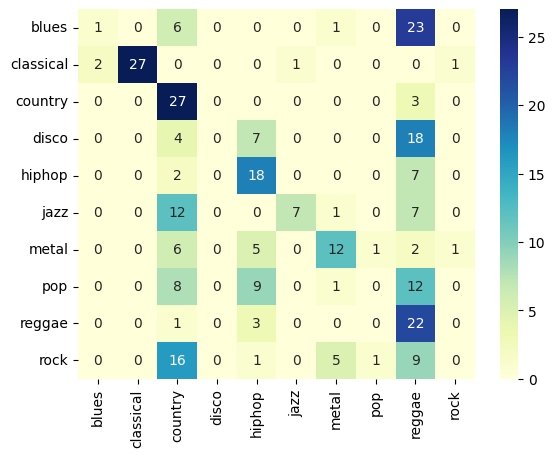

In [ ]:
#model = MLP().to(DEVICE)
evaluation(resnet) #evaluate using test data

For the ResNet we get a final evaluation accuracy of 39.3%

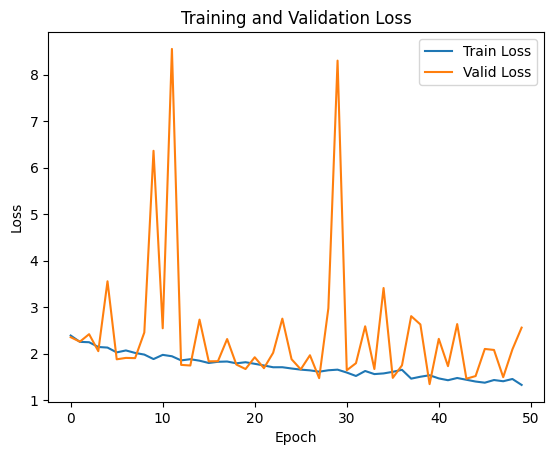

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses_resnet, label='Train Loss')
plt.plot(valid_losses_resnet, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

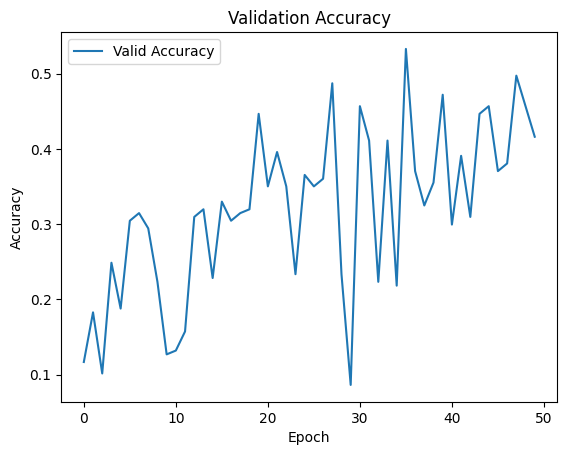

In [ ]:
#plt.plot(train_accuracy_resnet, label='Train Accuracy')
plt.plot(valid_accuracy_resnet, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

## Train UNet

In [ ]:
# Train UNet
num_epochs = 50
print(unet)
#print(train_wav.shape)
print(summary(unet,train_wav.shape)) #[16,1024,128]

UNet(
  (input): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (upconvs): ModuleList(
      (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2)

In [ ]:
train_losses_unet, valid_losses_unet, valid_accuracy_unet = train_loop(num_epochs, unet, criterion, unet_optimizer, train_loader, valid_loader)
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
#num_epochs = 50
#for epoch in range(num_epochs):
#    train_loss, train_acc = train(unet, unet_optimizer, criterion, train_loader, device)
#    test_loss, test_acc = test(unet, criterion, valid_loader, device) # use validation data

#    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Validation Loss: {test_loss:.4f}, Validation Acc: {test_acc:.2f}%')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: [1/50], Train loss: 2.3089


  2%|▏         | 1/50 [01:09<57:00, 69.80s/it]

Epoch: [1/50], Valid loss: 2.3042, Valid accuracy: 0.0812
Saving the best model at 0 epochs!
Epoch: [2/50], Train loss: 2.3071


  4%|▍         | 2/50 [02:18<55:24, 69.26s/it]

Epoch: [2/50], Valid loss: 2.2909, Valid accuracy: 0.0914
Saving the best model at 1 epochs!
Epoch: [3/50], Train loss: 2.3011


  6%|▌         | 3/50 [03:25<53:24, 68.17s/it]

Epoch: [3/50], Valid loss: 2.2526, Valid accuracy: 0.1117
Saving the best model at 2 epochs!
Epoch: [4/50], Train loss: 2.2859


  8%|▊         | 4/50 [04:33<52:05, 67.94s/it]

Epoch: [4/50], Valid loss: 2.2162, Valid accuracy: 0.1675
Saving the best model at 3 epochs!
Epoch: [5/50], Train loss: 2.2578


 10%|█         | 5/50 [05:41<51:07, 68.16s/it]

Epoch: [5/50], Valid loss: 2.2063, Valid accuracy: 0.1827
Saving the best model at 4 epochs!
Epoch: [6/50], Train loss: 2.2317


 12%|█▏        | 6/50 [06:52<50:43, 69.18s/it]

Epoch: [6/50], Valid loss: 2.2216, Valid accuracy: 0.1117
Epoch: [7/50], Train loss: 2.2605


 14%|█▍        | 7/50 [08:01<49:32, 69.12s/it]

Epoch: [7/50], Valid loss: 2.1833, Valid accuracy: 0.2183
Saving the best model at 6 epochs!
Epoch: [8/50], Train loss: 2.2391


 16%|█▌        | 8/50 [09:09<48:06, 68.73s/it]

Epoch: [8/50], Valid loss: 2.2046, Valid accuracy: 0.1675
Epoch: [9/50], Train loss: 2.2306


 18%|█▊        | 9/50 [10:18<46:54, 68.64s/it]

Epoch: [9/50], Valid loss: 2.1103, Valid accuracy: 0.2132
Saving the best model at 8 epochs!
Epoch: [10/50], Train loss: 2.2149


 20%|██        | 10/50 [11:25<45:26, 68.17s/it]

Epoch: [10/50], Valid loss: 2.1408, Valid accuracy: 0.1929
Epoch: [11/50], Train loss: 2.2115


 22%|██▏       | 11/50 [12:29<43:33, 67.01s/it]

Epoch: [11/50], Valid loss: 2.1954, Valid accuracy: 0.1929
Epoch: [12/50], Train loss: 2.2029


 24%|██▍       | 12/50 [13:36<42:26, 67.01s/it]

Epoch: [12/50], Valid loss: 2.1558, Valid accuracy: 0.1929
Epoch: [13/50], Train loss: 2.2022


 26%|██▌       | 13/50 [14:44<41:31, 67.35s/it]

Epoch: [13/50], Valid loss: 2.0819, Valid accuracy: 0.2030
Saving the best model at 12 epochs!
Epoch: [14/50], Train loss: 2.1930


 28%|██▊       | 14/50 [15:55<41:03, 68.42s/it]

Epoch: [14/50], Valid loss: 2.1726, Valid accuracy: 0.2234
Epoch: [15/50], Train loss: 2.1949


 30%|███       | 15/50 [17:05<40:08, 68.81s/it]

Epoch: [15/50], Valid loss: 2.2290, Valid accuracy: 0.1827
Epoch: [16/50], Train loss: 2.2642


 32%|███▏      | 16/50 [18:14<39:04, 68.96s/it]

Epoch: [16/50], Valid loss: 2.2198, Valid accuracy: 0.1624
Epoch: [17/50], Train loss: 2.2054


 34%|███▍      | 17/50 [19:22<37:42, 68.55s/it]

Epoch: [17/50], Valid loss: 2.0939, Valid accuracy: 0.2183
Epoch: [18/50], Train loss: 2.2050


 36%|███▌      | 18/50 [20:32<36:51, 69.10s/it]

Epoch: [18/50], Valid loss: 2.1146, Valid accuracy: 0.1777
Epoch: [19/50], Train loss: 2.1964


 38%|███▊      | 19/50 [21:40<35:25, 68.57s/it]

Epoch: [19/50], Valid loss: 2.0652, Valid accuracy: 0.2132
Saving the best model at 18 epochs!
Epoch: [20/50], Train loss: 2.2052


 40%|████      | 20/50 [22:50<34:29, 68.99s/it]

Epoch: [20/50], Valid loss: 2.1749, Valid accuracy: 0.2183
Epoch: [21/50], Train loss: 2.1868


 42%|████▏     | 21/50 [24:00<33:35, 69.49s/it]

Epoch: [21/50], Valid loss: 2.0777, Valid accuracy: 0.1929
Epoch: [22/50], Train loss: 2.1988


 44%|████▍     | 22/50 [25:08<32:13, 69.04s/it]

Epoch: [22/50], Valid loss: 2.0950, Valid accuracy: 0.1980
Epoch: [23/50], Train loss: 2.1863


 46%|████▌     | 23/50 [26:16<30:54, 68.69s/it]

Epoch: [23/50], Valid loss: 2.0764, Valid accuracy: 0.2081
Epoch: [24/50], Train loss: 2.1594


 48%|████▊     | 24/50 [27:26<29:53, 68.97s/it]

Epoch: [24/50], Valid loss: 2.1482, Valid accuracy: 0.1675
Epoch: [25/50], Train loss: 2.1716


 50%|█████     | 25/50 [28:34<28:40, 68.84s/it]

Epoch: [25/50], Valid loss: 2.0434, Valid accuracy: 0.1878
Saving the best model at 24 epochs!
Epoch: [26/50], Train loss: 2.1088


 52%|█████▏    | 26/50 [29:44<27:35, 68.99s/it]

Epoch: [26/50], Valid loss: 1.9982, Valid accuracy: 0.2183
Saving the best model at 25 epochs!
Epoch: [27/50], Train loss: 2.1160


 54%|█████▍    | 27/50 [30:54<26:36, 69.42s/it]

Epoch: [27/50], Valid loss: 2.0142, Valid accuracy: 0.2132
Epoch: [28/50], Train loss: 2.0997


 56%|█████▌    | 28/50 [32:03<25:26, 69.39s/it]

Epoch: [28/50], Valid loss: 1.9616, Valid accuracy: 0.2741
Saving the best model at 27 epochs!
Epoch: [29/50], Train loss: 2.0794


 58%|█████▊    | 29/50 [33:14<24:23, 69.68s/it]

Epoch: [29/50], Valid loss: 2.0134, Valid accuracy: 0.2132
Epoch: [30/50], Train loss: 2.1219


 60%|██████    | 30/50 [34:24<23:17, 69.88s/it]

Epoch: [30/50], Valid loss: 2.2325, Valid accuracy: 0.1878
Epoch: [31/50], Train loss: 2.1092


 62%|██████▏   | 31/50 [35:33<22:02, 69.58s/it]

Epoch: [31/50], Valid loss: 1.9757, Valid accuracy: 0.2741
Epoch: [32/50], Train loss: 2.0665


 64%|██████▍   | 32/50 [36:39<20:32, 68.48s/it]

Epoch: [32/50], Valid loss: 2.1906, Valid accuracy: 0.2589
Epoch: [33/50], Train loss: 2.0586


 66%|██████▌   | 33/50 [37:47<19:23, 68.45s/it]

Epoch: [33/50], Valid loss: 1.9487, Valid accuracy: 0.2030
Saving the best model at 32 epochs!
Epoch: [34/50], Train loss: 2.0303


 68%|██████▊   | 34/50 [38:56<18:15, 68.45s/it]

Epoch: [34/50], Valid loss: 1.9962, Valid accuracy: 0.2132
Epoch: [35/50], Train loss: 2.0256


 70%|███████   | 35/50 [40:03<17:01, 68.10s/it]

Epoch: [35/50], Valid loss: 1.9045, Valid accuracy: 0.2792
Saving the best model at 34 epochs!
Epoch: [36/50], Train loss: 1.9880


 72%|███████▏  | 36/50 [41:10<15:50, 67.89s/it]

Epoch: [36/50], Valid loss: 1.8531, Valid accuracy: 0.3604
Saving the best model at 35 epochs!
Epoch: [37/50], Train loss: 1.9637


 74%|███████▍  | 37/50 [42:20<14:48, 68.32s/it]

Epoch: [37/50], Valid loss: 1.8935, Valid accuracy: 0.2843
Epoch: [38/50], Train loss: 2.0488


 76%|███████▌  | 38/50 [43:30<13:47, 68.97s/it]

Epoch: [38/50], Valid loss: 2.2414, Valid accuracy: 0.1574
Epoch: [39/50], Train loss: 2.0482


 78%|███████▊  | 39/50 [44:38<12:33, 68.51s/it]

Epoch: [39/50], Valid loss: 1.8370, Valid accuracy: 0.3604
Saving the best model at 38 epochs!
Epoch: [40/50], Train loss: 1.9666


 80%|████████  | 40/50 [45:42<11:12, 67.28s/it]

Epoch: [40/50], Valid loss: 1.9534, Valid accuracy: 0.2690
Epoch: [41/50], Train loss: 1.9714


 82%|████████▏ | 41/50 [46:50<10:06, 67.41s/it]

Epoch: [41/50], Valid loss: 1.8126, Valid accuracy: 0.3198
Saving the best model at 40 epochs!
Epoch: [42/50], Train loss: 1.9375


 84%|████████▍ | 42/50 [47:56<08:56, 67.02s/it]

Epoch: [42/50], Valid loss: 1.8750, Valid accuracy: 0.3452
Epoch: [43/50], Train loss: 1.8479


 86%|████████▌ | 43/50 [49:04<07:52, 67.48s/it]

Epoch: [43/50], Valid loss: 2.2458, Valid accuracy: 0.3249
Epoch: [44/50], Train loss: 1.8878


 88%|████████▊ | 44/50 [50:12<06:44, 67.49s/it]

Epoch: [44/50], Valid loss: 1.8285, Valid accuracy: 0.3249
Epoch: [45/50], Train loss: 1.8930


 90%|█████████ | 45/50 [51:20<05:38, 67.64s/it]

Epoch: [45/50], Valid loss: 1.7416, Valid accuracy: 0.4112
Saving the best model at 44 epochs!
Epoch: [46/50], Train loss: 1.8713


 92%|█████████▏| 46/50 [52:32<04:35, 68.94s/it]

Epoch: [46/50], Valid loss: 2.1634, Valid accuracy: 0.2640
Epoch: [47/50], Train loss: 1.8207


 94%|█████████▍| 47/50 [53:40<03:26, 68.69s/it]

Epoch: [47/50], Valid loss: 1.9174, Valid accuracy: 0.3249
Epoch: [48/50], Train loss: 1.8884


 96%|█████████▌| 48/50 [54:51<02:18, 69.29s/it]

Epoch: [48/50], Valid loss: 1.8197, Valid accuracy: 0.3096
Epoch: [49/50], Train loss: 1.8762


 98%|█████████▊| 49/50 [55:59<01:09, 69.04s/it]

Epoch: [49/50], Valid loss: 2.2096, Valid accuracy: 0.2843
Epoch: [50/50], Train loss: 1.8696


100%|██████████| 50/50 [57:09<00:00, 68.59s/it]

Epoch: [50/50], Valid loss: 1.8101, Valid accuracy: 0.3807


Accuracy: 0.4207


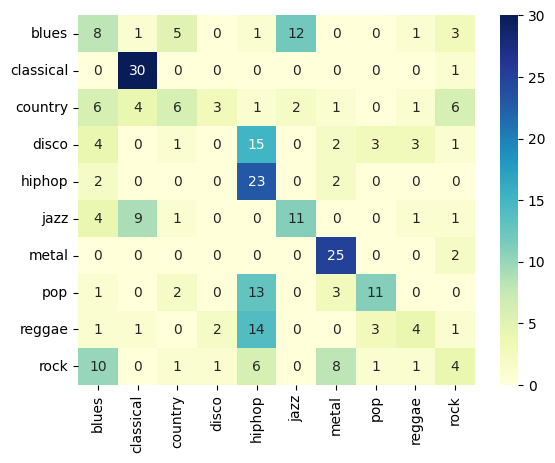

In [ ]:
evaluation(unet) #evaluate using test data

For the UNet we get a final evaluation accuracy of 42%

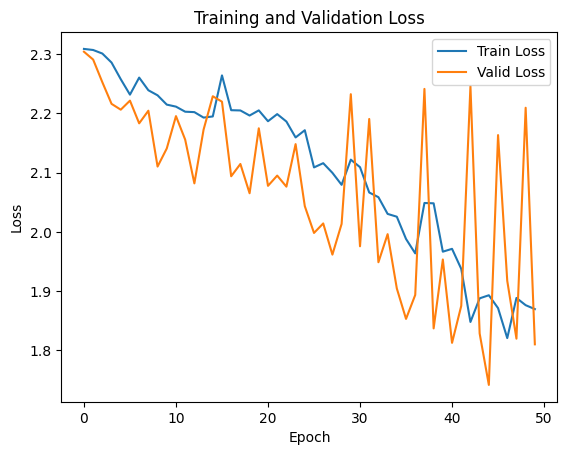

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses_unet, label='Train Loss')
plt.plot(valid_losses_unet, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

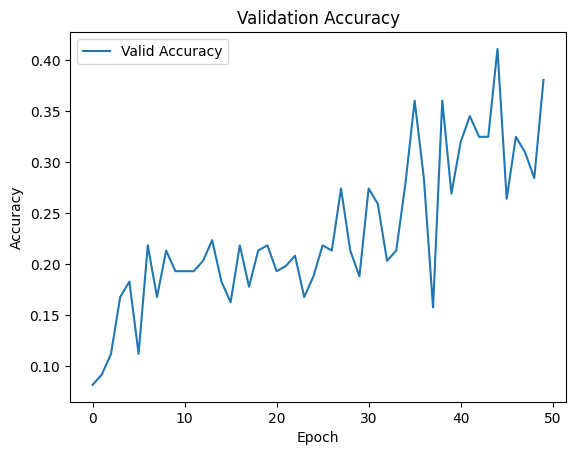

In [ ]:
#plt.plot(train_accuracy_unet, label='Train Accuracy')
plt.plot(valid_accuracy_unet, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# Brian
## FC MLP
## Audio Spectrogram Transformer

In [ ]:
class MLP(nn.Module):
    def __init__(self, sample_rate=SAMPLE_RATE,
                       n_fft=1024,
                       f_min=0.0,
                       f_max=11025.0,
                       num_mels=128,
                       num_classes=10):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1024*128, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
        )
        self.input_bn = nn.BatchNorm1d(1)

    def forward(self, x):
        out = x.unsqueeze(1)
        out = self.input_bn(out)

        y_ = self.network(x)

        return y_

class AST(nn.Module):
    def __init__(self, sample_rate=SAMPLE_RATE,
                       n_fft=1024,
                       f_min=0.0,
                       f_max=11025.0,
                       num_mels=128,
                       num_classes=10):
        super(AST, self).__init__()
        self.network = ASTForAudioClassification(configuration)

    def forward(self, x):
        y_ = self.network(x,return_dict=False)[0]

        return y_

def train_loop(num_epochs, model, criterion, optimizer, train_loader, valid_loader):
    valid_losses = []
    for epoch in tqdm(range(num_epochs)):
        losses = []

        # Train
        model.train()
        for x, y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            y_pred = model(x)
            loss = criterion(y_pred, y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))

        # Validation
        model.eval()
        y_true_list = []
        y_pred_list = []
        losses = []
        for x, y in valid_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            y_pred = model(x)
            loss = criterion(y_pred, y)
            losses.append(loss.item())
            _, pred = torch.max(y_pred, 1)

            # append labels and predictions
            y_true_list.extend(y.tolist())
            y_pred_list.extend(pred.tolist())
        accuracy = accuracy_score(y_true_list, y_pred_list)
        valid_loss = np.mean(losses)
        print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))
        # Save model
        valid_losses.append(valid_loss.item())
        if np.argmin(valid_losses) == epoch:
            print('Saving the best model at %d epochs!' % epoch)
            torch.save(model.state_dict(), 'best_model.ckpt')

def evaluation(model, loader, test=True):
    S = torch.load('best_model.ckpt')
    model.load_state_dict(S)

    # Run evaluation
    model.eval()
    y_true_list = []
    y_pred_list = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            y_pred = model(x)
            _, pred = torch.max(y_pred, 1)

            # append labels and predictions
            y_true_list.extend(y.tolist())
            y_pred_list.extend(pred.tolist())
    accuracy = accuracy_score(y_true_list, y_pred_list)
    if test:
        cm = confusion_matrix(y_true_list, y_pred_list)
        sns.heatmap(cm, annot=True, xticklabels=GTZAN_GENRES, yticklabels=GTZAN_GENRES, cmap='YlGnBu')
    print('Accuracy: %.4f' % accuracy)


In [ ]:
num_epochs = 50

model = AST().to(DEVICE)
print(model)
print(summary(model, train_wav.shape))

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loop(num_epochs, model, criterion, optimizer, train_loader, valid_loader)



AST(
  (network): ASTForAudioClassification(
    (audio_spectrogram_transformer): ASTModel(
      (embeddings): ASTEmbeddings(
        (patch_embeddings): ASTPatchEmbeddings(
          (projection): Conv2d(1, 384, kernel_size=(16, 16), stride=(10, 10))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ASTEncoder(
        (layer): ModuleList(
          (0-2): 3 x ASTLayer(
            (attention): ASTAttention(
              (attention): ASTSelfAttention(
                (query): Linear(in_features=384, out_features=384, bias=True)
                (key): Linear(in_features=384, out_features=384, bias=True)
                (value): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ASTSelfOutput(
                (dense): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: [1/50], Train loss: 2.4768


  2%|▏         | 1/50 [01:26<1:10:16, 86.06s/it]

Epoch: [1/50], Valid loss: 2.3897, Valid accuracy: 0.1269
Saving the best model at 0 epochs!
Epoch: [2/50], Train loss: 2.3368


  4%|▍         | 2/50 [02:50<1:08:04, 85.08s/it]

Epoch: [2/50], Valid loss: 2.3477, Valid accuracy: 0.1827
Saving the best model at 1 epochs!
Epoch: [3/50], Train loss: 2.3291


  6%|▌         | 3/50 [04:08<1:04:11, 81.95s/it]

Epoch: [3/50], Valid loss: 2.3113, Valid accuracy: 0.1168
Saving the best model at 2 epochs!
Epoch: [4/50], Train loss: 2.3464


  8%|▊         | 4/50 [05:25<1:01:21, 80.03s/it]

Epoch: [4/50], Valid loss: 2.4213, Valid accuracy: 0.0914
Epoch: [5/50], Train loss: 2.3575


 10%|█         | 5/50 [06:46<1:00:11, 80.25s/it]

Epoch: [5/50], Valid loss: 2.3080, Valid accuracy: 0.1523
Saving the best model at 4 epochs!
Epoch: [6/50], Train loss: 2.2941


 12%|█▏        | 6/50 [08:05<58:27, 79.72s/it]  

Epoch: [6/50], Valid loss: 2.3181, Valid accuracy: 0.1168
Epoch: [7/50], Train loss: 2.2697


 14%|█▍        | 7/50 [09:24<57:01, 79.58s/it]

Epoch: [7/50], Valid loss: 2.3849, Valid accuracy: 0.1421
Epoch: [8/50], Train loss: 2.2720


 16%|█▌        | 8/50 [10:38<54:35, 77.99s/it]

Epoch: [8/50], Valid loss: 2.3996, Valid accuracy: 0.1117
Epoch: [9/50], Train loss: 2.3016


 18%|█▊        | 9/50 [11:57<53:22, 78.12s/it]

Epoch: [9/50], Valid loss: 2.2965, Valid accuracy: 0.1218
Saving the best model at 8 epochs!
Epoch: [10/50], Train loss: 2.2820


 20%|██        | 10/50 [13:15<52:05, 78.13s/it]

Epoch: [10/50], Valid loss: 2.3268, Valid accuracy: 0.1371
Epoch: [11/50], Train loss: 2.2817


 22%|██▏       | 11/50 [14:33<50:50, 78.21s/it]

Epoch: [11/50], Valid loss: 2.2796, Valid accuracy: 0.1168
Saving the best model at 10 epochs!
Epoch: [12/50], Train loss: 2.2826


 24%|██▍       | 12/50 [15:51<49:22, 77.96s/it]

Epoch: [12/50], Valid loss: 2.3281, Valid accuracy: 0.1269
Epoch: [13/50], Train loss: 2.2665


 26%|██▌       | 13/50 [17:07<47:47, 77.51s/it]

Epoch: [13/50], Valid loss: 2.3044, Valid accuracy: 0.0914
Epoch: [14/50], Train loss: 2.2504


 28%|██▊       | 14/50 [18:27<46:56, 78.24s/it]

Epoch: [14/50], Valid loss: 2.2842, Valid accuracy: 0.1827
Epoch: [15/50], Train loss: 2.2882


 30%|███       | 15/50 [19:47<45:54, 78.71s/it]

Epoch: [15/50], Valid loss: 2.4010, Valid accuracy: 0.1574
Epoch: [16/50], Train loss: 2.2735


 32%|███▏      | 16/50 [21:01<43:50, 77.37s/it]

Epoch: [16/50], Valid loss: 2.2709, Valid accuracy: 0.1066
Saving the best model at 15 epochs!
Epoch: [17/50], Train loss: 2.2713


 34%|███▍      | 17/50 [22:35<45:16, 82.31s/it]

Epoch: [17/50], Valid loss: 2.3124, Valid accuracy: 0.1015
Epoch: [18/50], Train loss: 2.2786


 36%|███▌      | 18/50 [23:55<43:29, 81.56s/it]

Epoch: [18/50], Valid loss: 2.2988, Valid accuracy: 0.1269
Epoch: [19/50], Train loss: 2.2737


 38%|███▊      | 19/50 [25:09<40:58, 79.32s/it]

Epoch: [19/50], Valid loss: 2.2199, Valid accuracy: 0.1320
Saving the best model at 18 epochs!
Epoch: [20/50], Train loss: 2.2108


 40%|████      | 20/50 [26:29<39:41, 79.40s/it]

Epoch: [20/50], Valid loss: 2.2131, Valid accuracy: 0.1777
Saving the best model at 19 epochs!
Epoch: [21/50], Train loss: 2.2541


 42%|████▏     | 21/50 [27:46<38:01, 78.68s/it]

Epoch: [21/50], Valid loss: 2.2316, Valid accuracy: 0.1269
Epoch: [22/50], Train loss: 2.2403


 44%|████▍     | 22/50 [29:04<36:42, 78.65s/it]

Epoch: [22/50], Valid loss: 2.2813, Valid accuracy: 0.1218
Epoch: [23/50], Train loss: 2.2636


 46%|████▌     | 23/50 [30:22<35:13, 78.29s/it]

Epoch: [23/50], Valid loss: 2.2562, Valid accuracy: 0.1472
Epoch: [24/50], Train loss: 2.2426


 48%|████▊     | 24/50 [31:40<33:53, 78.21s/it]

Epoch: [24/50], Valid loss: 2.1988, Valid accuracy: 0.1675
Saving the best model at 23 epochs!
Epoch: [25/50], Train loss: 2.1783


 50%|█████     | 25/50 [32:51<31:45, 76.24s/it]

Epoch: [25/50], Valid loss: 2.1718, Valid accuracy: 0.1675
Saving the best model at 24 epochs!
Epoch: [26/50], Train loss: 2.2387


 52%|█████▏    | 26/50 [34:08<30:34, 76.42s/it]

Epoch: [26/50], Valid loss: 2.2126, Valid accuracy: 0.1371
Epoch: [27/50], Train loss: 2.2158


 54%|█████▍    | 27/50 [35:27<29:31, 77.02s/it]

Epoch: [27/50], Valid loss: 2.2449, Valid accuracy: 0.2132
Epoch: [28/50], Train loss: 2.2473


 56%|█████▌    | 28/50 [36:48<28:43, 78.33s/it]

Epoch: [28/50], Valid loss: 2.1562, Valid accuracy: 0.2234
Saving the best model at 27 epochs!
Epoch: [29/50], Train loss: 2.1552


 58%|█████▊    | 29/50 [38:05<27:14, 77.82s/it]

Epoch: [29/50], Valid loss: 2.0543, Valid accuracy: 0.2487
Saving the best model at 28 epochs!
Epoch: [30/50], Train loss: 2.2796


 60%|██████    | 30/50 [39:23<25:58, 77.92s/it]

Epoch: [30/50], Valid loss: 2.2188, Valid accuracy: 0.1472
Epoch: [31/50], Train loss: 2.1943


 62%|██████▏   | 31/50 [40:42<24:47, 78.26s/it]

Epoch: [31/50], Valid loss: 2.2282, Valid accuracy: 0.1878
Epoch: [32/50], Train loss: 2.1805


 64%|██████▍   | 32/50 [41:58<23:15, 77.55s/it]

Epoch: [32/50], Valid loss: 2.1319, Valid accuracy: 0.2589
Epoch: [33/50], Train loss: 2.1296


 66%|██████▌   | 33/50 [43:17<22:09, 78.20s/it]

Epoch: [33/50], Valid loss: 2.0704, Valid accuracy: 0.2640
Epoch: [34/50], Train loss: 2.1158


 68%|██████▊   | 34/50 [44:36<20:53, 78.32s/it]

Epoch: [34/50], Valid loss: 2.0880, Valid accuracy: 0.2284
Epoch: [35/50], Train loss: 2.1606


 70%|███████   | 35/50 [45:54<19:32, 78.16s/it]

Epoch: [35/50], Valid loss: 2.2345, Valid accuracy: 0.1168
Epoch: [36/50], Train loss: 2.1032


 72%|███████▏  | 36/50 [47:12<18:13, 78.11s/it]

Epoch: [36/50], Valid loss: 2.0834, Valid accuracy: 0.2640
Epoch: [37/50], Train loss: 2.1743


 74%|███████▍  | 37/50 [48:29<16:50, 77.76s/it]

Epoch: [37/50], Valid loss: 2.1029, Valid accuracy: 0.2589
Epoch: [38/50], Train loss: 2.1808


 76%|███████▌  | 38/50 [49:48<15:37, 78.10s/it]

Epoch: [38/50], Valid loss: 2.3856, Valid accuracy: 0.1269
Epoch: [39/50], Train loss: 2.2749


 78%|███████▊  | 39/50 [51:06<14:19, 78.11s/it]

Epoch: [39/50], Valid loss: 2.1938, Valid accuracy: 0.2081
Epoch: [40/50], Train loss: 2.1924


 80%|████████  | 40/50 [52:24<13:02, 78.26s/it]

Epoch: [40/50], Valid loss: 2.1977, Valid accuracy: 0.2030
Epoch: [41/50], Train loss: 2.1794


 82%|████████▏ | 41/50 [53:43<11:44, 78.30s/it]

Epoch: [41/50], Valid loss: 2.1449, Valid accuracy: 0.1726
Epoch: [42/50], Train loss: 2.1499


 84%|████████▍ | 42/50 [55:02<10:27, 78.46s/it]

Epoch: [42/50], Valid loss: 2.1498, Valid accuracy: 0.2030
Epoch: [43/50], Train loss: 2.1889


 86%|████████▌ | 43/50 [56:18<09:04, 77.76s/it]

Epoch: [43/50], Valid loss: 2.1868, Valid accuracy: 0.1726
Epoch: [44/50], Train loss: 2.1839


 88%|████████▊ | 44/50 [57:37<07:49, 78.24s/it]

Epoch: [44/50], Valid loss: 2.2652, Valid accuracy: 0.1523
Epoch: [45/50], Train loss: 2.1556


 90%|█████████ | 45/50 [58:55<06:31, 78.28s/it]

Epoch: [45/50], Valid loss: 2.1435, Valid accuracy: 0.2386
Epoch: [46/50], Train loss: 2.1195


 92%|█████████▏| 46/50 [1:00:14<05:13, 78.33s/it]

Epoch: [46/50], Valid loss: 2.1546, Valid accuracy: 0.1675
Epoch: [47/50], Train loss: 2.1451


 94%|█████████▍| 47/50 [1:01:33<03:55, 78.64s/it]

Epoch: [47/50], Valid loss: 2.1889, Valid accuracy: 0.1726
Epoch: [48/50], Train loss: 2.2190


 96%|█████████▌| 48/50 [1:02:56<02:39, 79.92s/it]

Epoch: [48/50], Valid loss: 2.1633, Valid accuracy: 0.2030
Epoch: [49/50], Train loss: 2.1607


 98%|█████████▊| 49/50 [1:04:15<01:19, 79.62s/it]

Epoch: [49/50], Valid loss: 2.1491, Valid accuracy: 0.1929
Epoch: [50/50], Train loss: 2.1266


100%|██████████| 50/50 [1:05:35<00:00, 78.72s/it]

Epoch: [50/50], Valid loss: 2.1354, Valid accuracy: 0.2284


Accuracy: 0.2302
Accuracy: 0.2448


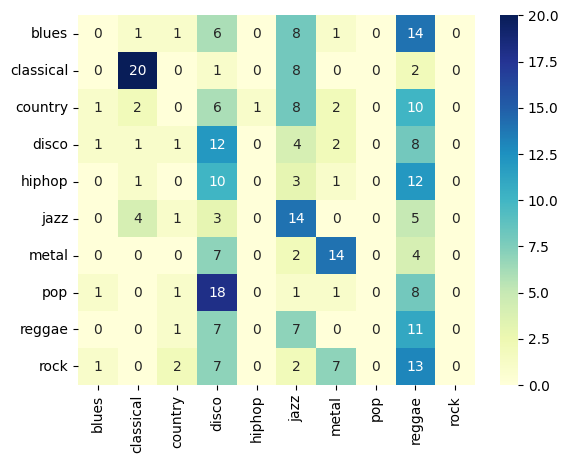

In [ ]:
model = AST().to(DEVICE)
evaluation(model, train_loader, False)
evaluation(model, test_loader)

For the AST (Transformer) we get a final evaluation accuracy of 24%

In [ ]:
num_epochs = 50

model = MLP().to(DEVICE)
print(model)
print(summary(model, train_wav.shape))

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loop(num_epochs, model, criterion, optimizer, train_loader, valid_loader)


MLP(
  (network): Sequential(
    (0): Linear(in_features=131072, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU()
    (10): Linear(in_features=50, out_features=10, bias=True)
  )
  (input_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [16, 10]                  2
├─Sequential: 1-1                        [16, 10]                  --
│    └─Linear: 2-1                       [16, 30]                  3,932,190
│    └─ReLU: 2-2                         [16, 30]                  --
│    └─Linear: 2-3                       [16, 50]            

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: [1/50], Train loss: 2.4104


  2%|▏         | 1/50 [01:11<58:11, 71.25s/it]

Epoch: [1/50], Valid loss: 2.3176, Valid accuracy: 0.0812
Saving the best model at 0 epochs!
Epoch: [2/50], Train loss: 2.3183


  4%|▍         | 2/50 [02:24<57:43, 72.17s/it]

Epoch: [2/50], Valid loss: 2.2248, Valid accuracy: 0.1929
Saving the best model at 1 epochs!
Epoch: [3/50], Train loss: 2.2774


  6%|▌         | 3/50 [03:32<55:02, 70.26s/it]

Epoch: [3/50], Valid loss: 2.2146, Valid accuracy: 0.1929
Saving the best model at 2 epochs!
Epoch: [4/50], Train loss: 2.2268


  8%|▊         | 4/50 [04:40<53:25, 69.69s/it]

Epoch: [4/50], Valid loss: 2.2376, Valid accuracy: 0.1624
Epoch: [5/50], Train loss: 2.2450


 10%|█         | 5/50 [05:49<52:00, 69.35s/it]

Epoch: [5/50], Valid loss: 2.2343, Valid accuracy: 0.1371
Epoch: [6/50], Train loss: 2.2492


 12%|█▏        | 6/50 [06:57<50:25, 68.77s/it]

Epoch: [6/50], Valid loss: 2.1810, Valid accuracy: 0.1777
Saving the best model at 5 epochs!
Epoch: [7/50], Train loss: 2.2037


 14%|█▍        | 7/50 [08:05<49:14, 68.70s/it]

Epoch: [7/50], Valid loss: 2.1402, Valid accuracy: 0.1878
Saving the best model at 6 epochs!
Epoch: [8/50], Train loss: 2.1981


 16%|█▌        | 8/50 [09:16<48:30, 69.29s/it]

Epoch: [8/50], Valid loss: 2.1595, Valid accuracy: 0.2538
Epoch: [9/50], Train loss: 2.2082


 18%|█▊        | 9/50 [10:23<46:57, 68.72s/it]

Epoch: [9/50], Valid loss: 2.1488, Valid accuracy: 0.2487
Epoch: [10/50], Train loss: 2.1803


 20%|██        | 10/50 [11:32<45:45, 68.64s/it]

Epoch: [10/50], Valid loss: 2.0904, Valid accuracy: 0.2132
Saving the best model at 9 epochs!
Epoch: [11/50], Train loss: 2.2101


 22%|██▏       | 11/50 [12:38<44:12, 68.02s/it]

Epoch: [11/50], Valid loss: 2.1900, Valid accuracy: 0.2538
Epoch: [12/50], Train loss: 2.2028


 24%|██▍       | 12/50 [13:46<43:02, 67.96s/it]

Epoch: [12/50], Valid loss: 2.1324, Valid accuracy: 0.1827
Epoch: [13/50], Train loss: 2.1721


 26%|██▌       | 13/50 [14:51<41:19, 67.01s/it]

Epoch: [13/50], Valid loss: 2.1617, Valid accuracy: 0.1878
Epoch: [14/50], Train loss: 2.1977


 28%|██▊       | 14/50 [16:00<40:31, 67.54s/it]

Epoch: [14/50], Valid loss: 2.1269, Valid accuracy: 0.2386
Epoch: [15/50], Train loss: 2.1718


 30%|███       | 15/50 [17:10<39:54, 68.40s/it]

Epoch: [15/50], Valid loss: 2.1137, Valid accuracy: 0.1777
Epoch: [16/50], Train loss: 2.1755


 32%|███▏      | 16/50 [18:16<38:19, 67.65s/it]

Epoch: [16/50], Valid loss: 2.1690, Valid accuracy: 0.2081
Epoch: [17/50], Train loss: 2.2038


 34%|███▍      | 17/50 [19:20<36:34, 66.50s/it]

Epoch: [17/50], Valid loss: 2.1128, Valid accuracy: 0.2335
Epoch: [18/50], Train loss: 2.1610


 36%|███▌      | 18/50 [20:28<35:41, 66.93s/it]

Epoch: [18/50], Valid loss: 2.1491, Valid accuracy: 0.2132
Epoch: [19/50], Train loss: 2.1386


 38%|███▊      | 19/50 [21:35<34:35, 66.96s/it]

Epoch: [19/50], Valid loss: 2.0965, Valid accuracy: 0.2081
Epoch: [20/50], Train loss: 2.1408


 40%|████      | 20/50 [22:44<33:47, 67.60s/it]

Epoch: [20/50], Valid loss: 2.1416, Valid accuracy: 0.1980
Epoch: [21/50], Train loss: 2.1503


 42%|████▏     | 21/50 [23:49<32:17, 66.81s/it]

Epoch: [21/50], Valid loss: 2.0819, Valid accuracy: 0.2183
Saving the best model at 20 epochs!
Epoch: [22/50], Train loss: 2.1222


 44%|████▍     | 22/50 [24:58<31:32, 67.61s/it]

Epoch: [22/50], Valid loss: 2.2010, Valid accuracy: 0.1726
Epoch: [23/50], Train loss: 2.1731


 46%|████▌     | 23/50 [26:11<31:03, 69.01s/it]

Epoch: [23/50], Valid loss: 2.0871, Valid accuracy: 0.2335
Epoch: [24/50], Train loss: 2.1161


 48%|████▊     | 24/50 [27:19<29:50, 68.88s/it]

Epoch: [24/50], Valid loss: 2.1296, Valid accuracy: 0.2234
Epoch: [25/50], Train loss: 2.1610


 50%|█████     | 25/50 [28:29<28:48, 69.13s/it]

Epoch: [25/50], Valid loss: 2.0823, Valid accuracy: 0.2030
Epoch: [26/50], Train loss: 2.1371


 52%|█████▏    | 26/50 [29:35<27:17, 68.21s/it]

Epoch: [26/50], Valid loss: 2.0691, Valid accuracy: 0.2386
Saving the best model at 25 epochs!
Epoch: [27/50], Train loss: 2.1673


 54%|█████▍    | 27/50 [30:37<25:25, 66.34s/it]

Epoch: [27/50], Valid loss: 2.0775, Valid accuracy: 0.2741
Epoch: [28/50], Train loss: 2.1066


 56%|█████▌    | 28/50 [31:43<24:19, 66.33s/it]

Epoch: [28/50], Valid loss: 2.0629, Valid accuracy: 0.2437
Saving the best model at 27 epochs!
Epoch: [29/50], Train loss: 2.1443


 58%|█████▊    | 29/50 [32:51<23:22, 66.77s/it]

Epoch: [29/50], Valid loss: 2.0545, Valid accuracy: 0.2487
Saving the best model at 28 epochs!
Epoch: [30/50], Train loss: 2.0790


 60%|██████    | 30/50 [33:56<22:03, 66.19s/it]

Epoch: [30/50], Valid loss: 2.2772, Valid accuracy: 0.2234
Epoch: [31/50], Train loss: 2.1347


 62%|██████▏   | 31/50 [35:04<21:06, 66.66s/it]

Epoch: [31/50], Valid loss: 2.0488, Valid accuracy: 0.2335
Saving the best model at 30 epochs!
Epoch: [32/50], Train loss: 2.1158


 64%|██████▍   | 32/50 [36:10<19:59, 66.62s/it]

Epoch: [32/50], Valid loss: 2.0345, Valid accuracy: 0.2487
Saving the best model at 31 epochs!
Epoch: [33/50], Train loss: 2.0743


 66%|██████▌   | 33/50 [37:19<19:04, 67.35s/it]

Epoch: [33/50], Valid loss: 1.9890, Valid accuracy: 0.2792
Saving the best model at 32 epochs!
Epoch: [34/50], Train loss: 2.1230


 68%|██████▊   | 34/50 [38:28<18:02, 67.64s/it]

Epoch: [34/50], Valid loss: 2.0967, Valid accuracy: 0.2081
Epoch: [35/50], Train loss: 2.1282


 70%|███████   | 35/50 [39:37<17:03, 68.21s/it]

Epoch: [35/50], Valid loss: 2.0925, Valid accuracy: 0.2538
Epoch: [36/50], Train loss: 2.1120


 72%|███████▏  | 36/50 [40:45<15:52, 68.04s/it]

Epoch: [36/50], Valid loss: 2.0839, Valid accuracy: 0.2437
Epoch: [37/50], Train loss: 2.0617


 74%|███████▍  | 37/50 [41:54<14:47, 68.30s/it]

Epoch: [37/50], Valid loss: 2.0431, Valid accuracy: 0.2741
Epoch: [38/50], Train loss: 2.1141


 76%|███████▌  | 38/50 [43:02<13:38, 68.17s/it]

Epoch: [38/50], Valid loss: 2.0598, Valid accuracy: 0.2284
Epoch: [39/50], Train loss: 2.0741


 78%|███████▊  | 39/50 [44:07<12:19, 67.24s/it]

Epoch: [39/50], Valid loss: 1.9197, Valid accuracy: 0.2995
Saving the best model at 38 epochs!
Epoch: [40/50], Train loss: 2.0986


 80%|████████  | 40/50 [45:15<11:15, 67.51s/it]

Epoch: [40/50], Valid loss: 2.0770, Valid accuracy: 0.2487
Epoch: [41/50], Train loss: 2.1096


 82%|████████▏ | 41/50 [46:24<10:13, 68.15s/it]

Epoch: [41/50], Valid loss: 2.0263, Valid accuracy: 0.2335
Epoch: [42/50], Train loss: 2.0750


 84%|████████▍ | 42/50 [47:33<09:07, 68.40s/it]

Epoch: [42/50], Valid loss: 1.9712, Valid accuracy: 0.2640
Epoch: [43/50], Train loss: 2.0384


 86%|████████▌ | 43/50 [48:39<07:53, 67.62s/it]

Epoch: [43/50], Valid loss: 1.9912, Valid accuracy: 0.2640
Epoch: [44/50], Train loss: 2.1021


 88%|████████▊ | 44/50 [49:43<06:39, 66.58s/it]

Epoch: [44/50], Valid loss: 1.9424, Valid accuracy: 0.2944
Epoch: [45/50], Train loss: 2.0629


 90%|█████████ | 45/50 [50:49<05:31, 66.21s/it]

Epoch: [45/50], Valid loss: 1.9834, Valid accuracy: 0.2690
Epoch: [46/50], Train loss: 2.0745


 92%|█████████▏| 46/50 [51:54<04:23, 65.88s/it]

Epoch: [46/50], Valid loss: 1.9843, Valid accuracy: 0.2995
Epoch: [47/50], Train loss: 2.0390


 94%|█████████▍| 47/50 [53:00<03:18, 66.04s/it]

Epoch: [47/50], Valid loss: 2.1026, Valid accuracy: 0.2538
Epoch: [48/50], Train loss: 2.1385


 96%|█████████▌| 48/50 [54:06<02:12, 66.10s/it]

Epoch: [48/50], Valid loss: 2.0241, Valid accuracy: 0.2640
Epoch: [49/50], Train loss: 2.0676


 98%|█████████▊| 49/50 [55:13<01:06, 66.33s/it]

Epoch: [49/50], Valid loss: 1.9176, Valid accuracy: 0.3147
Saving the best model at 48 epochs!
Epoch: [50/50], Train loss: 2.0560


100%|██████████| 50/50 [56:17<00:00, 67.56s/it]

Epoch: [50/50], Valid loss: 2.0237, Valid accuracy: 0.2538


Accuracy: 0.2483
Accuracy: 0.3172


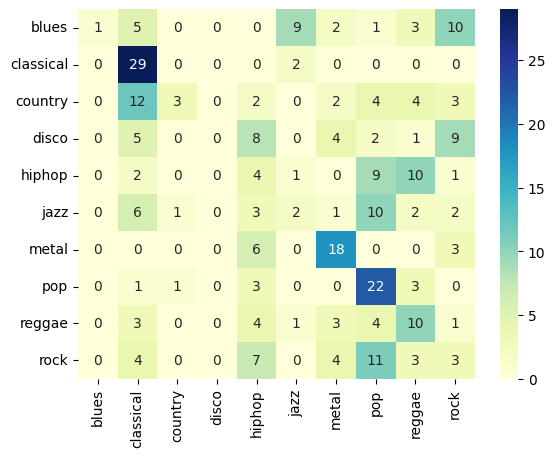

In [ ]:
model = MLP().to(DEVICE)
evaluation(model, train_loader, False)
evaluation(model, test_loader)

For the MLP we get a final evaluate accuracy of 31.7%

In conclusion we got alot of great data from this.


*   For the classifiers like Linear Regression and SVM we found that they didnt perform well on this dataset due to their simplicity, and even when we had a version of the Logistic regession with 4.4 million parameters it was still the worst performing model of them all
*   For models like the MLP and Transformer they performer better than the classifiers but not by much. The MLP performing the better of the two. These two models were large at 4.0 and 4.1 million parameters respectively and took a long time and alot of memory to train.
*   Finally the models that performed the best on this dataset were the CNN's, ResNet and UNet. This was expected as we were using the spectogram to process the data, using this image based method the models best suited to classify image data excelled.
*   Depsite the accuracies of all the models being relatively low, this is still a success as we were able to get these results under the constraints of a very small batch size of 16, small to medium parameter sizes, and only training for 50 epochs. Had we trained for longer, say 70 or 100 epochs, we'd definetly be getting greater accuracies. However, for our experiment standardizing the requirements was necessary due to extremely long training times and memory constraints.

